In [4]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
from google.colab import drive
drive.mount('/content/drive')

import zipfile
zip_path = '/content/drive/MyDrive/Dataset/archive.zip'
extract_path = '/content/pascal_voc'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset extracted to:", extract_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset extracted to: /content/pascal_voc


In [6]:
import os
import xml.etree.ElementTree as ET
import cv2
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from PIL import Image
from sklearn.model_selection import train_test_split
import random

In [7]:
ann_dir = '/content/pascal_voc/VOC2012_train_val/VOC2012_train_val/Annotations'
img_dir = '/content/pascal_voc/VOC2012_train_val/VOC2012_train_val/JPEGImages'

def draw_boxes(image_path, annotation_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    tree = ET.parse(annotation_path)
    root = tree.getroot()
    for obj in root.findall('object'):
        label = obj.find('name').text
        bbox = obj.find('bndbox')
        x1 = int(bbox.find('xmin').text)
        y1 = int(bbox.find('ymin').text)
        x2 = int(bbox.find('xmax').text)
        y2 = int(bbox.find('ymax').text)
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(image, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)
    return image


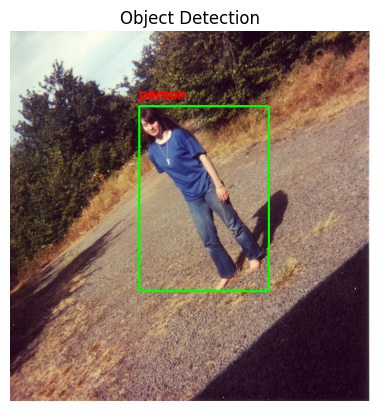

In [8]:
test_img = '2007_000027.jpg'
img_path = os.path.join(img_dir, test_img)
ann_path = os.path.join(ann_dir, test_img.replace('.jpg', '.xml'))

img = draw_boxes(img_path, ann_path)
plt.imshow(img)
plt.axis('off')
plt.title("Object Detection")
plt.show()

In [9]:
def build_unet(input_shape=(128, 128, 3), num_classes=21):
    inputs = Input(input_shape)
    c1 = Conv2D(32, 3, activation='relu', padding='same')(inputs)
    c1 = Conv2D(32, 3, activation='relu', padding='same')(c1)
    p1 = MaxPooling2D()(c1)

    c2 = Conv2D(64, 3, activation='relu', padding='same')(p1)
    c2 = Conv2D(64, 3, activation='relu', padding='same')(c2)
    p2 = MaxPooling2D()(c2)

    c3 = Conv2D(128, 3, activation='relu', padding='same')(p2)
    c3 = Conv2D(128, 3, activation='relu', padding='same')(c3)

    u1 = Conv2DTranspose(64, 2, strides=2, padding='same')(c3)
    u1 = concatenate([u1, c2])
    c4 = Conv2D(64, 3, activation='relu', padding='same')(u1)

    u2 = Conv2DTranspose(32, 2, strides=2, padding='same')(c4)
    u2 = concatenate([u2, c1])
    c5 = Conv2D(32, 3, activation='relu', padding='same')(u2)

    outputs = Conv2D(num_classes, 1, activation='softmax')(c5)
    return Model(inputs, outputs)

unet_model = build_unet()
unet_model.compile(optimizer='adam', loss='categorical_crossentropy')
unet_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    147,584 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 64, 64,    │     32,832 │ conv2d_5[0][0]    │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 64,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 128)              │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 64, 64,    │     73,792 │ concatenate[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 128, 128,  │      8,224 │ conv2d_6[0][0]    │
│ (Conv2DTranspose)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 128, 128,  │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 64)               │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 128, 128,  │     18,464 │ concatenate_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 128, 128,  │        693 │ conv2d_7[0][0]    │
│                     │ 21)               │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 421,013 (1.61 MB)

 Trainable params: 421,013 (1.61 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
def extract_labels(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    labels = [obj.find('name').text for obj in root.findall('object')]
    return list(set(labels))

In [11]:
def generate_caption_from_objects(labels):
    if not labels:
        return "an image with no detectable objects"
    elif len(labels) == 1:
        return f"a photo showing a {labels[0]}"
    else:
        return f"a photo showing {', '.join(labels[:-1])} and {labels[-1]}"

Detected objects: ['person']
Generated caption: a photo showing a person


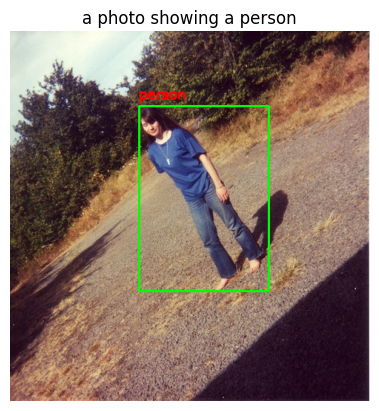

In [12]:
labels = extract_labels(ann_path)
caption = generate_caption_from_objects(labels)

print("Detected objects:", labels)
print("Generated caption:", caption)

img = draw_boxes(img_path, ann_path)
plt.imshow(img)
plt.axis('off')
plt.title(caption)
plt.show()

In [13]:
seg_img_dir = '/content/pascal_voc/VOC2012_train_val/VOC2012_train_val/JPEGImages'
seg_mask_dir = '/content/pascal_voc/VOC2012_train_val/VOC2012_train_val/SegmentationClass'

# Filter out images that have masks
image_ids = [f[:-4] for f in os.listdir(seg_mask_dir) if f.endswith('.png')]
print("Total segmentation samples:", len(image_ids))

Total segmentation samples: 2913


In [14]:
IMG_SIZE = 128
NUM_CLASSES = 21  # Pascal VOC classes

def load_image(path):
    img = Image.open(path).resize((IMG_SIZE, IMG_SIZE))
    return np.array(img)

def load_mask(path):
    mask = Image.open(path).resize((IMG_SIZE, IMG_SIZE), resample=Image.NEAREST)
    mask = np.array(mask)
    return to_categorical(mask, num_classes=NUM_CLASSES)

X, Y = [], []
for img_id in image_ids[:200]:  # You can increase this for full training
    img_path = os.path.join(seg_img_dir, f"{img_id}.jpg")
    mask_path = os.path.join(seg_mask_dir, f"{img_id}.png")
    try:
        X.append(load_image(img_path))
        Y.append(load_mask(mask_path))
    except:
        continue

X = np.array(X) / 255.0
Y = np.array(Y)
print("Shapes:", X.shape, Y.shape)

Shapes: (200, 128, 128, 3) (0,)


In [18]:
X, Y = [], []
for img_id in image_ids[:200]:
    img_path = os.path.join(seg_img_dir, f"{img_id}.jpg")
    mask_path = os.path.join(seg_mask_dir, f"{img_id}.png")
    try:
        image = load_image(img_path)
        mask = load_mask(mask_path)
        if mask.shape[:2] != (IMG_SIZE, IMG_SIZE):
            continue
        X.append(image)
        Y.append(mask)
    except Exception as e:
        print(f"Skipping {img_id}: {e}")

Skipping 2011_001810: index 255 is out of bounds for axis 1 with size 21
Skipping 2010_004757: index 255 is out of bounds for axis 1 with size 21
Skipping 2007_003451: index 255 is out of bounds for axis 1 with size 21
Skipping 2009_005220: index 255 is out of bounds for axis 1 with size 21
Skipping 2008_000602: index 255 is out of bounds for axis 1 with size 21
Skipping 2010_002032: index 255 is out of bounds for axis 1 with size 21
Skipping 2007_008407: index 255 is out of bounds for axis 1 with size 21
Skipping 2011_000457: index 255 is out of bounds for axis 1 with size 21
Skipping 2010_004951: index 255 is out of bounds for axis 1 with size 21
Skipping 2007_009446: index 255 is out of bounds for axis 1 with size 21
Skipping 2011_000216: index 255 is out of bounds for axis 1 with size 21
Skipping 2007_009756: index 255 is out of bounds for axis 1 with size 21
Skipping 2007_008051: index 255 is out of bounds for axis 1 with size 21
Skipping 2008_004659: index 255 is out of bounds fo

In [19]:
VOC_COLORMAP = {
    (128, 0, 0): 0, (0, 128, 0): 1, (128, 128, 0): 2, (0, 0, 128): 3,
    (128, 0, 128): 4, (0, 128, 128): 5, (128, 128, 128): 6, (64, 0, 0): 7,
    (192, 0, 0): 8, (64, 128, 0): 9, (192, 128, 0): 10, (64, 0, 128): 11,
    (192, 0, 128): 12, (64, 128, 128): 13, (192, 128, 128): 14,
    (0, 64, 0): 15, (128, 64, 0): 16, (0, 192, 0): 17, (128, 192, 0): 18,
    (0, 64, 128): 19, (128, 64, 128): 20
}

def rgb_to_class(mask):
    h, w, _ = mask.shape
    class_mask = np.zeros((h, w), dtype=np.uint8)
    for rgb, class_id in VOC_COLORMAP.items():
        match = np.all(mask == rgb, axis=-1)
        class_mask[match] = class_id
    return class_mask

In [20]:
X, Y = [], []
for img_id in image_ids[:200]:
    img_path = os.path.join(seg_img_dir, f"{img_id}.jpg")
    mask_path = os.path.join(seg_mask_dir, f"{img_id}.png")
    try:
        img = Image.open(img_path).resize((IMG_SIZE, IMG_SIZE))
        mask = Image.open(mask_path).resize((IMG_SIZE, IMG_SIZE), resample=Image.NEAREST)
        img = np.array(img)
        mask = np.array(mask)
        if mask.ndim == 3:  # RGB mask
            mask = rgb_to_class(mask)
        X.append(img)
        Y.append(mask)
    except Exception as e:
        print(f"Skipping {img_id} due to: {e}")

In [21]:
X = np.array(X) / 255.0
Y = np.array(Y)
Y[Y == 255] = 0  # Replace ignore label with background (class 0)
Y = to_categorical(Y, num_classes=NUM_CLASSES)

print("Loaded:", X.shape, Y.shape)

Loaded: (200, 128, 128, 3) (200, 128, 128, 21)


In [22]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

print("Train:", X_train.shape, Y_train.shape)
print("Val:  ", X_val.shape, Y_val.shape)

Train: (160, 128, 128, 3) (160, 128, 128, 21)
Val:   (40, 128, 128, 3) (40, 128, 128, 21)


In [23]:
history = unet_model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    batch_size=8,
    epochs=20,
    verbose=1
)

Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 192ms/step - loss: 2.3145 - val_loss: 1.4216
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 1.4726 - val_loss: 1.3329
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 1.5314 - val_loss: 1.2023
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 1.3878 - val_loss: 1.2358
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 1.3409 - val_loss: 1.1537
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 1.2800 - val_loss: 1.1259
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 1.2698 - val_loss: 1.0891
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 1.2269 - val_loss: 1.0820
Epoch 9/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 1.2229 - val_loss: 1.1097
Epoch 10/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 1.2393 - val_loss: 1.0953
Epoch 11/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 1.2089 - val_loss: 1.1073
Epoch 12/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 1

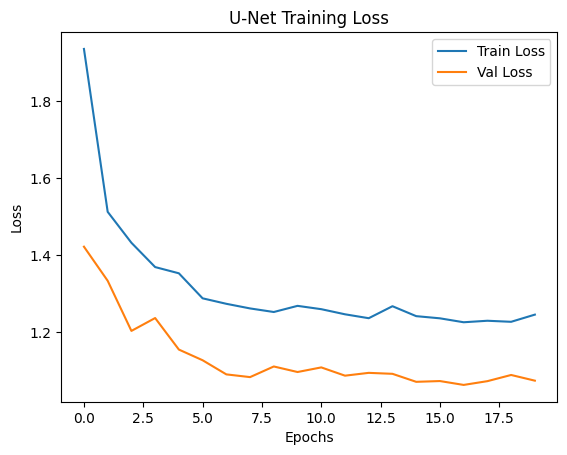

In [24]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("U-Net Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


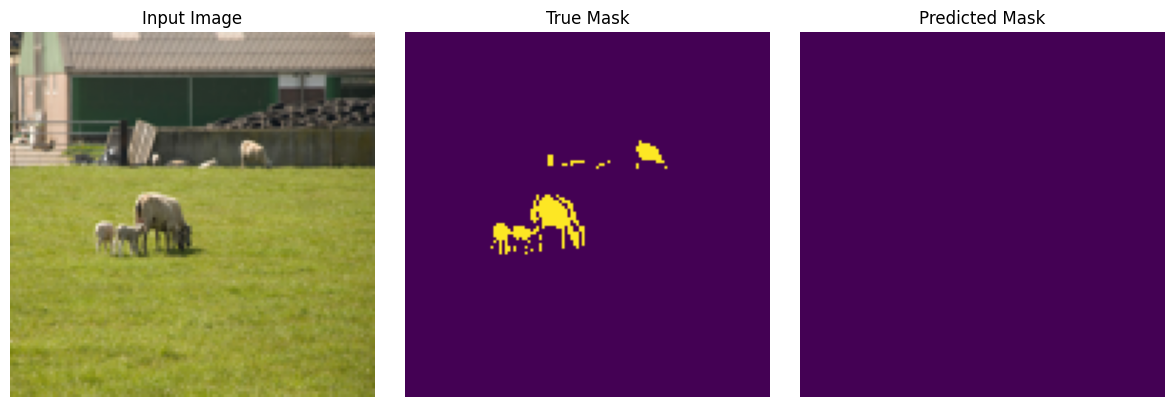

In [25]:
def visualize_segmentation(index=0):
    pred = unet_model.predict(X_val[index][np.newaxis, ...])
    pred_mask = np.argmax(pred[0], axis=-1)
    true_mask = np.argmax(Y_val[index], axis=-1)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(X_val[index])
    plt.title("Input Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(true_mask)
    plt.title("True Mask")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask)
    plt.title("Predicted Mask")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

visualize_segmentation(0)

In [26]:
VOC_COLORS = np.array([
    [128, 0, 0], [0, 128, 0], [128, 128, 0], [0, 0, 128], [128, 0, 128],
    [0, 128, 128], [128, 128, 128], [64, 0, 0], [192, 0, 0], [64, 128, 0],
    [192, 128, 0], [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
    [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0], [0, 64, 128],
    [128, 64, 128]
], dtype=np.uint8)

In [27]:
def decode_segmentation(mask):
    color_mask = VOC_COLORS[mask]
    return color_mask

def overlay_mask(image, mask, alpha=0.5):
    mask_color = decode_segmentation(mask)
    overlay = (alpha * image + (1 - alpha) * mask_color).astype(np.uint8)
    return overlay

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


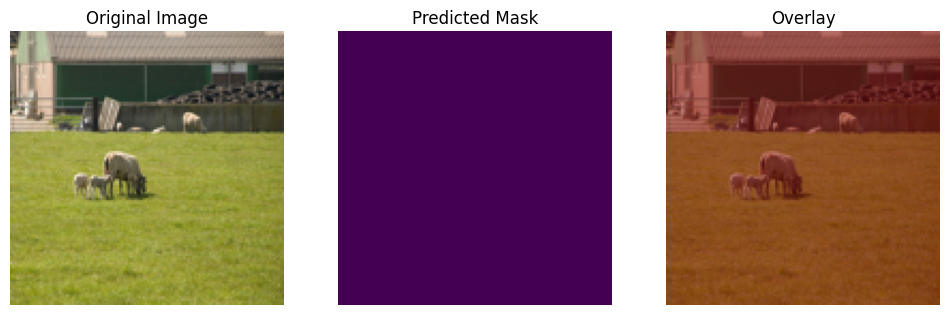

In [28]:
def show_overlay(index=0):
    image = (X_val[index] * 255).astype(np.uint8)
    pred = unet_model.predict(X_val[index][np.newaxis])[0]
    pred_mask = np.argmax(pred, axis=-1)

    overlay = overlay_mask(image, pred_mask)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(pred_mask)
    plt.title("Predicted Mask")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(overlay)
    plt.title("Overlay")
    plt.axis('off')
    plt.show()

show_overlay(0)

In [29]:
def final_visualization(img_id):
    img_path = os.path.join(img_dir, f"{img_id}.jpg")
    xml_path = os.path.join(ann_dir, f"{img_id}.xml")

    original_img = cv2.imread(img_path)
    original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
    resized_img = cv2.resize(original_img, (IMG_SIZE, IMG_SIZE))

    detected_img = draw_boxes(img_path, xml_path)
    detected_img = cv2.resize(detected_img, (IMG_SIZE, IMG_SIZE))

    input_img = resized_img.astype(np.float32) / 255.0
    pred = unet_model.predict(input_img[np.newaxis, ...])[0]
    pred_mask = np.argmax(pred, axis=-1)
    overlay_img = overlay_mask(resized_img, pred_mask)

    labels = extract_labels(xml_path)
    caption = generate_caption_from_objects(labels)

    plt.figure(figsize=(16, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(detected_img)
    plt.title("Object Detection")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(pred_mask)
    plt.title("Segmentation Mask")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(overlay_img)
    plt.title(f"Caption: {caption}")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

In [38]:
sample_ids = [f[:-4] for f in os.listdir(img_dir) if f.endswith('.jpg')]
random_samples = random.sample(sample_ids, 5)
print("Try any of these:", random_samples)

Try any of these: ['2008_003814', '2012_004268', '2008_003746', '2010_006455', '2009_001098']


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


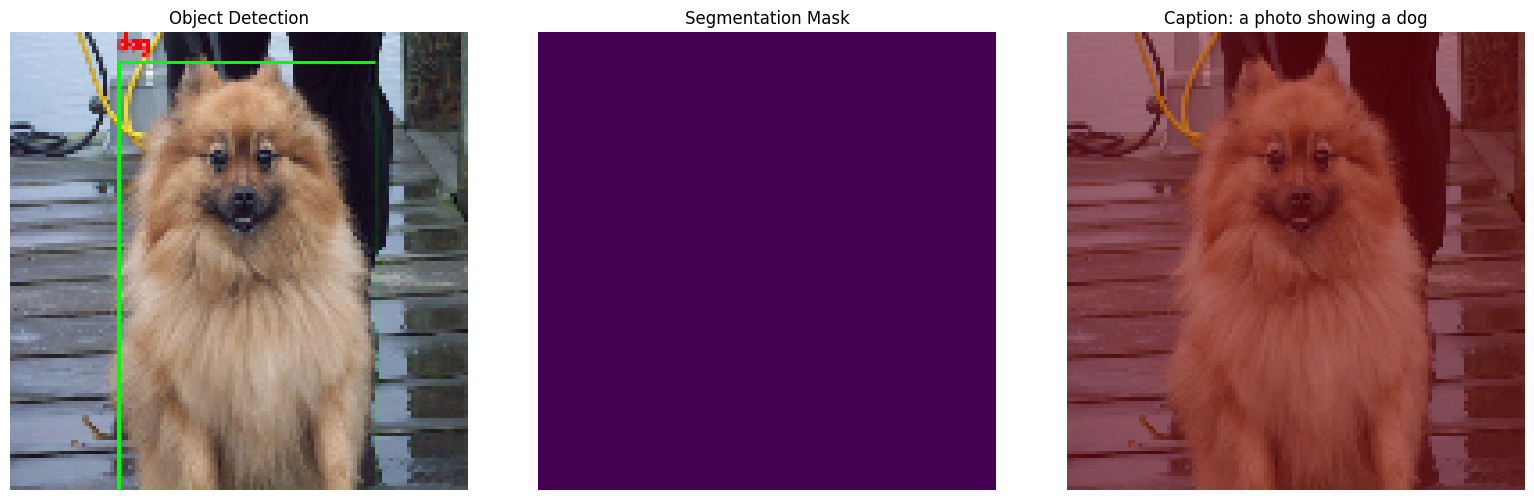

In [40]:
final_visualization("2008_003746")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


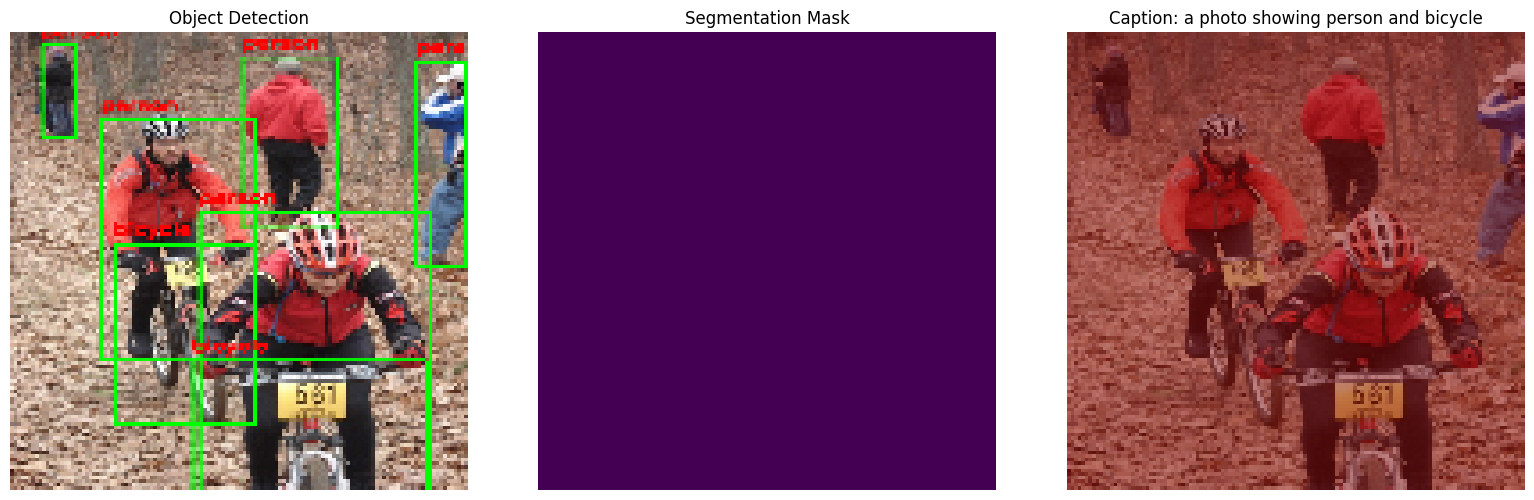

In [41]:
final_visualization("2007_001630")